In [1]:
import os
import rioxarray as riox
import xarray as xr
from hlsstack.utils.hpc_setup import launch_dask
import seaborn as sns
import numpy as np

In [2]:
# dask cluster location
cluster_loc = 'local'

# path to HLS biomass data
hls_path = '/90daydata/cper_neon_aop/hls_nrt/cper/hls_cp/cper_hls_cp_{}.nc'
lmf_path = '/90daydata/cper_neon_aop/hls_nrt/cper/lmf_cp/cper_lmf_cp_{}.nc'

# the range of years to be processed
yrs = range(2000, 2025)
# drop 2012 since it could not be processed by LMF
yrs = [x for x in yrs if x != 2012]

hls_yrs = list(np.arange(2015, 2025))
lmf_yrs = [x for x in np.arange(2000, 2015) if x != 2012]

In [3]:
# setup the dask cluster
if cluster_loc == 'local':
    #os.chdir(wkDIR)
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    cluster = LocalCluster(n_workers=24, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    import psutil
    interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0',
        'ibp24s0',
        'ib0'
    ]
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    num_jobs=24
    client = launch_dask(cluster_loc=cluster_loc,
                         num_jobs=num_jobs,
                         mem_gb_per=4.0,
                         partition='atlas', 
                         duration='02:00:00',
                         slurm_opts={'interface': interface},
                         extra_directives=["--account=cper_neon_aop"],
                         wait_timeout=300,
                         debug=False)
    display(client)

   setting up Local cluster...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 48,Total memory: 180.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40943,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 180.14 GiB
Comm: tcp://127.0.0.1:34071,Total threads: 2
Dashboard: http://127.0.0.1:39221/status,Memory: 7.51 GiB
Nanny: tcp://127.0.0.1:44115,


In [4]:
from tqdm import tqdm

In [5]:
chunks = {'time': -1, 'y': 20, 'x': 20}

In [6]:
ds_template = xr.open_dataset(hls_path.format(str(2024)))
ds_template = ds_template.rio.write_crs("EPSG:3857").rio.reproject("EPSG:32613")

In [13]:
ds

<xarray.Dataset>
Dimensions:  (y: 325, x: 325, time: 310)
Coordinates:
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x        (x) float64 5.176e+05 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * time     (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2000-12-30
Data variables:
    CP       (y, x, time) float32 nan nan nan nan ... 6.215 6.182 6.161 6.112

In [14]:
xr_cp_list = []
for idx, yr in enumerate(tqdm(yrs)):
    # define the file path
    if yr in hls_yrs:
        fpath = hls_path.format(str(yr))
        ds = xr.open_dataset(fpath)
        #ds = ds.drop(['spatial_ref'])#.chunk(chunks)
        ds = ds.rio.write_crs("EPSG:3857").rio.reproject("EPSG:32613")
        ds = ds.rename({'NDVI': 'CP'})
    elif yr in lmf_yrs:
        fpath = lmf_path.format(str(yr))
        ds = xr.open_dataset(fpath)
        ds = ds.drop(['spatial_ref', 'YEAR'])#.chunk(chunks)
        ds = ds.reindex({'y': ds_template.y, 'x': ds_template.x}, method='nearest', tolerance=30)
    #if type(ds) == xr.core.dataarray.DataArray:
    #    ds = ds.to_dataset()
    xr_cp_list.append(ds)

100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


In [15]:
ds_cp = xr.concat(xr_cp_list, dim='time', combine_attrs="drop_conflicts")
#ds_cp = xr.combine_by_coords(xr_bm_list, combine_attrs="drop_conflicts", data_vars=['Biomass'], coords=['x', 'y', 'time'])

In [16]:
ds_cp

<xarray.Dataset>
Dimensions:      (y: 325, x: 325, time: 8707)
Coordinates:
    spatial_ref  int64 0
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * time         (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2024-12-31
Data variables:
    CP           (y, x, time) float32 nan nan nan nan nan ... nan nan nan nan

In [109]:
#ds_cp = ds_cp.where(ds_cp > 0)

In [17]:
from datetime import datetime, timedelta

In [18]:
leapyear_mask = ds_cp.time.dt.is_leap_year & (ds_cp.time.dt.dayofyear > 59)#(ds_cp.time.dt.month == 2) & (ds_cp.time.dt.day == 29)

In [19]:
leapyear_mask

<xarray.DataArray (time: 8707)>
array([False, False, False, ...,  True,  True,  True])
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2024-12-31

In [20]:
day_coords = ds_cp.time.dt.dayofyear

In [21]:
# subtract a day for leap years
day_coords[leapyear_mask] = day_coords[leapyear_mask] - 1

In [22]:
ds_cp_daily = ds_cp.groupby(day_coords).mean()

<AxesSubplot:xlabel='dayofyear'>

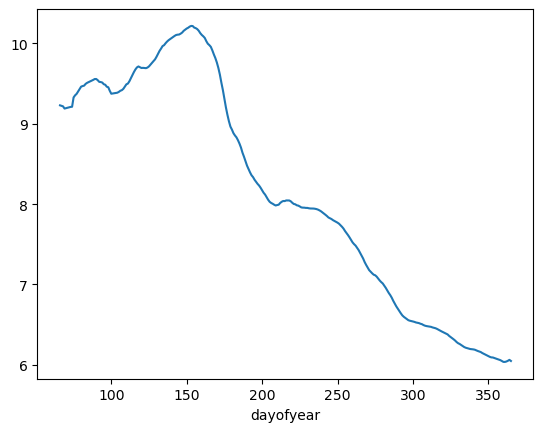

In [23]:
sns.lineplot(y=ds_cp_daily.isel(x=150, y=150)['CP'].values, x=ds_cp_daily.dayofyear)

In [24]:
ds_cp_daily.dayofyear//7 + 1

<xarray.DataArray 'dayofyear' (dayofyear: 365)>
array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25,
       25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27,
       27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30,
       30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32,
       32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35,
       35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37,
       37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39,
       40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42,
       42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44,
       44, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 47, 47,
       47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49,
       49, 49, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52,
       52, 52, 52, 52, 52, 52, 53, 53])
Coordinates:
    spatial_ref  int64 0
  * dayofyear    (dayofyear) int64 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365

In [25]:
ds_cp_wkly = ds_cp_daily.groupby(ds_cp_daily.dayofyear//7 + 1).mean()

In [26]:
ds_cp_wkly = ds_cp_wkly.rename({'dayofyear': 'week'})

In [27]:
ds_cp_wkly = ds_cp_wkly.sel(week=slice(1, 52))

In [28]:
ds_cp_wkly

<xarray.Dataset>
Dimensions:      (y: 325, x: 325, week: 52)
Coordinates:
    spatial_ref  int64 0
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * week         (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    CP           (week, y, x) float32 nan nan nan nan ... 6.009 5.827 5.873

<AxesSubplot:xlabel='week'>

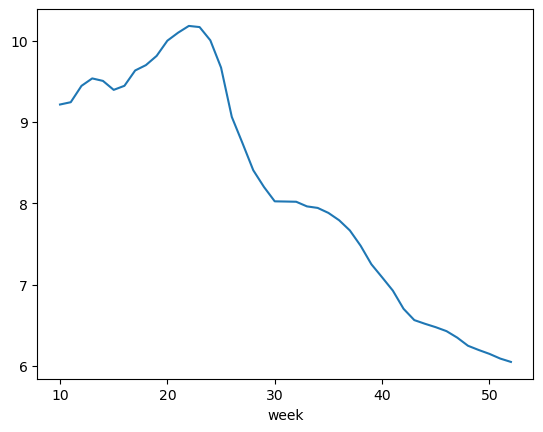

In [39]:
sns.lineplot(y=ds_cp_wkly.isel(x=150, y=150)['CP'].values, x=ds_cp_wkly.week)

In [30]:
ds_cp_wkly = ds_cp_wkly.rio.write_transform(ds_template.rio.transform())
ds_cp_wkly = ds_cp_wkly.rio.write_crs(ds_template.rio.crs)

ds_cp_wkly.to_netcdf('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_cp_lta_wkly_2000_2024.nc')
os.chmod('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_cp_lta_wkly_2000_2024.nc', 0o777)

ds_cp_wkly.rio.reproject("EPSG:3857").to_netcdf('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_cp_lta_wkly_2000_2024_gcloud.nc')
os.chmod('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_cp_lta_wkly_2000_2024_gcloud.nc', 0o777)

In [31]:
ds_cp_wkly_hls = ds_cp.where(ds_cp.time.dt.year > 2014).groupby(ds_cp.time.dt.isocalendar().week).mean()

In [34]:
ds_cp_wkly_hls = ds_cp_wkly_hls.sel(week=slice(1, 52))

<AxesSubplot:xlabel='week'>

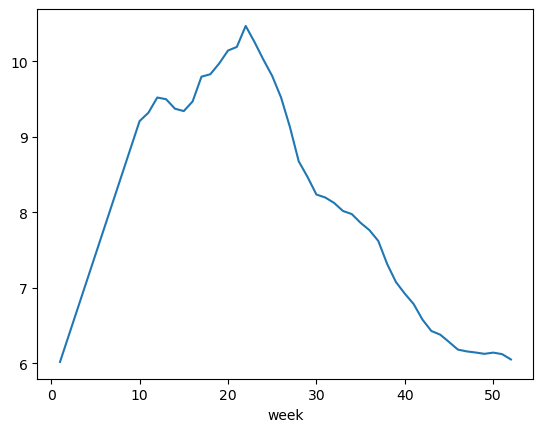

In [35]:
sns.lineplot(y=ds_cp_wkly_hls.isel(x=150, y=150)['CP'].values, x=ds_cp_wkly_hls.week)

In [36]:
ds_cp_wkly_lmf = ds_cp.where(ds_cp.time.dt.year <= 2014).groupby(ds_cp.time.dt.isocalendar().week).mean()

In [37]:
ds_cp_wkly_lmf = ds_cp_wkly_lmf.sel(week=slice(1, 52))

<AxesSubplot:xlabel='week'>

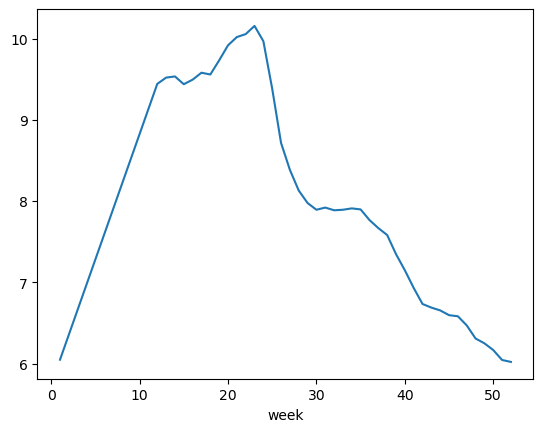

In [38]:
sns.lineplot(y=ds_cp_wkly_lmf.isel(x=150, y=150)['CP'].values, x=ds_cp_wkly_lmf.week)

In [40]:
from rasterio.plot import show

In [41]:
fpath = lmf_path.format(str(2010))
ds = xr.open_dataset(fpath)

In [42]:
ds.reindex({'y': ds_template.y, 'x': ds_template.x}, method='nearest', tolerance=30)

<xarray.Dataset>
Dimensions:      (y: 325, x: 325, time: 364)
Coordinates:
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
    YEAR         int32 ...
    spatial_ref  int64 ...
Data variables:
    CP           (y, x, time) float32 nan nan nan nan ... 5.637 5.683 5.73 5.776

In [43]:
ds_template

<xarray.Dataset>
Dimensions:      (x: 325, y: 325, time: 366)
Coordinates:
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * time         (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-12-31
    spatial_ref  int64 0
Data variables:
    NDVI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [44]:
ds = ds.reindex({'y': ds_template.y, 'x': ds_template.x}, method='nearest', tolerance=30)

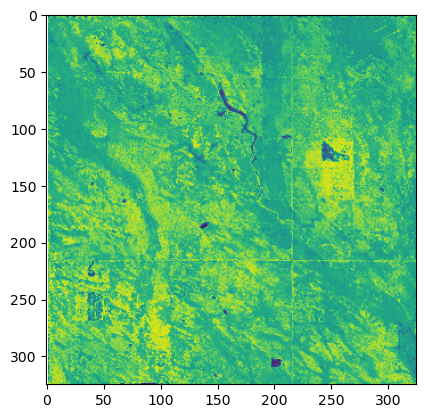

<AxesSubplot:>

In [45]:
show(ds['CP'].isel(time=150).data)

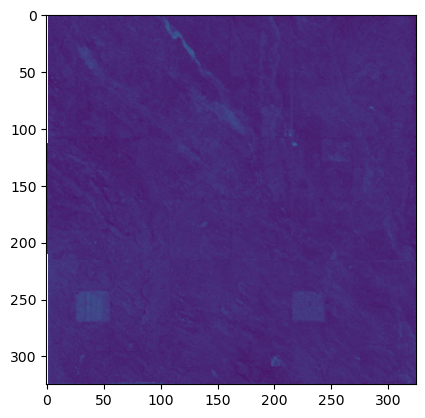

<AxesSubplot:>

In [51]:
show(ds_cp_wkly['CP'].isel(week=40).data, vmin=6, vmax=12)

In [62]:
inDIR = '/90daydata/cper_neon_aop/hls_nrt/'
prefix = 'cper'
yr=2025

In [77]:
import geopandas as gpd
from hlsstack.hls_funcs.masks import shp2mask
import pandas as pd

In [72]:
# open existing HLS dataset from disk for year specified above as template
ds = riox.open_rasterio(os.path.join(inDIR, 'gcloud', 'hls_' + prefix + '_' + str(yr) + '_gcloud.nc'), masked=True)
# load CPER pasture data and covert to mask (currently only works for CPER)
if prefix == 'cper':
    #cper_f = '/project/cper_neon_aop/hls_nrt/data/ground/cper_pastures_2017_dissolved.shp'
    cper_f = '/project/cper_neon_aop/py_hls_nrt/data/ground/cper_pastures_2025_w_carm3_zones_w_excl.shp'
    cper = gpd.read_file(cper_f).to_crs(ds.rio.crs.to_epsg())
    cper = cper.rename(columns={'Viewer_ID': 'Pasture'})
    cper_info = cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
    past_dict[0] = 'UNK'
    cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]
    cper_mask = shp2mask(shp=cper_mask_shp, 
                         transform=ds.rio.transform(), 
                         outshape=ds['NDVI'].shape[1:], 
                         xr_object=ds['NDVI'])
    past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)

# assign pasture mask to HLS dataset
ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
ds = ds.set_coords('Pasture')

In [64]:
# open existing long-term average crude protein (calculated from LMF and HLS)
ds_cp_lta = riox.open_rasterio(os.path.join(inDIR, 'hls_lmf_lta', prefix + '_cp_lta_wkly_2000_2024_gcloud.nc'), masked=True)
# set meaningless date for long-term average data to allow overlay in the app
ds_cp_lta = ds_cp_lta.rename({'week': 'date'})
ds_cp_lta['date'] = [datetime(2099, 1, 1) + timedelta(weeks=int(w)) for w in ds_cp_lta['date'].values]
# reset the index of long-term data to match the HLS data
ds_cp_lta = ds_cp_lta.reindex({'y': ds.y, 'x': ds.x}, method='nearest', tolerance=30)

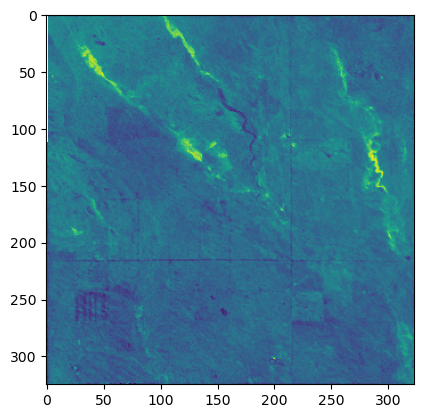

<AxesSubplot:>

In [66]:
#ds_cp_lta = riox.open_rasterio(os.path.join(inDIR, 'hls_lmf_lta', prefix + '_cp_lta_wkly_2000_2024_gcloud.nc'), masked=True)
show(ds_cp_lta.isel(date=30).data)

In [114]:
### Long term averages
# open existing long-term average NDVI (calculated from earth engine)
ds_ndvi_lta = riox.open_rasterio(os.path.join(inDIR, 'ee_lta', prefix + '_ee_ndvi_landsat_wkly_lta.nc'), masked=True)
# set meaningless date for long-term average data to allow overlay in the app
#ds_ndvi_lta['date'] = [datetime.strptime(re.sub('2020', '2099', str(x)),'%Y-%m-%d %H:%M:%S') for x in ds_ndvi_lta['date'].values]
ds_ndvi_lta['date'] = [datetime(2099, 1, 1) + timedelta(weeks=int(w)) for w in [pd.to_datetime(x.isoformat()).week for x in ds_ndvi_lta.indexes['date'].values]]
# reset the index of long-term data to match the HLS data
ds_ndvi_lta = ds_ndvi_lta.reindex({'y': ds.y, 'x': ds.x}, method='nearest', tolerance=30)

In [115]:
# open existing long-term average biomass (calculated from LMF and HLS)
ds_bm_lta = riox.open_rasterio(os.path.join(inDIR, 'hls_lmf_lta', prefix + '_bm_lta_wkly_2000_2024_gcloud.nc'), masked=True)
# set meaningless date for long-term average data to allow overlay in the app
ds_bm_lta = ds_bm_lta.rename({'week': 'date'})
ds_bm_lta['date'] = [datetime(2099, 1, 1) + timedelta(weeks=int(w)) for w in ds_bm_lta['date'].values]
# reset the index of long-term data to match the HLS data
ds_bm_lta = ds_bm_lta.reindex({'y': ds.y, 'x': ds.x}, method='nearest', tolerance=30)

In [116]:
# open existing long-term average crude protein (calculated from LMF and HLS)
ds_cp_lta = riox.open_rasterio(os.path.join(inDIR, 'hls_lmf_lta', prefix + '_cp_lta_wkly_2000_2024_gcloud.nc'), masked=True)
# set meaningless date for long-term average data to allow overlay in the app
ds_cp_lta = ds_cp_lta.rename({'week': 'date'})
ds_cp_lta['date'] = [datetime(2099, 1, 1) + timedelta(weeks=int(w)) for w in ds_cp_lta['date'].values]
# reset the index of long-term data to match the HLS data
ds_cp_lta = ds_cp_lta.reindex({'y': ds.y, 'x': ds.x}, method='nearest', tolerance=30)

In [117]:
# get long-term average NDVI data as a dataframe
df_ndvi_lta = ds_ndvi_lta.groupby(ds['Pasture']).mean(dim='stacked_y_x').to_dataframe().reset_index().drop(columns='spatial_ref')
df_ndvi_lta['Year'] = 'long-term avg.'
df_ndvi_lta_aoi = ds_ndvi_lta.mean(dim=['y', 'x']).to_dataframe().reset_index().drop(columns='spatial_ref')
df_ndvi_lta_aoi['Pasture'] = prefix
df_ndvi_lta_aoi['Year'] = 'long-term avg.'

In [118]:
# get long-term average biomass data as a dataframe
df_bm_lta = ds_bm_lta.groupby(ds['Pasture']).mean(dim='stacked_y_x').to_dataframe().reset_index().drop(columns='spatial_ref')
df_bm_lta['Year'] = 'long-term avg.'
df_bm_lta_aoi = ds_bm_lta.mean(dim=['y', 'x']).to_dataframe().reset_index().drop(columns='spatial_ref')
df_bm_lta_aoi['Pasture'] = prefix
df_bm_lta_aoi['Year'] = 'long-term avg.'

In [119]:
# get long-term average crude protein data as a dataframe
df_cp_lta = ds_cp_lta.groupby(ds['Pasture']).mean(dim='stacked_y_x').to_dataframe().reset_index().drop(columns='spatial_ref')
df_cp_lta['Year'] = 'long-term avg.'
df_cp_lta_aoi = ds_cp_lta.mean(dim=['y', 'x']).to_dataframe().reset_index().drop(columns='spatial_ref')
df_cp_lta_aoi['Pasture'] = prefix
df_cp_lta_aoi['Year'] = 'long-term avg.'

# merge all long-term datasets
df_lta = pd.merge(
    pd.merge(
        pd.concat([df_bm_lta, df_bm_lta_aoi]), pd.concat([df_ndvi_lta, df_ndvi_lta_aoi]), 
        how='left', on=['date', 'Pasture', 'Year']),
    pd.concat([df_cp_lta, df_cp_lta_aoi]),
    how='left', on=['date', 'Pasture', 'Year'])

In [120]:
df_lta

,date,Pasture,Biomass,Year,NDVI,CP
0,2099-01-08,12C,640.003174,long-term avg.,0.134414,NaN
1,2099-01-08,12NW,625.725586,long-term avg.,0.129657,NaN
2,2099-01-08,12NWcorner,560.040405,long-term avg.,0.176062,NaN
3,2099-01-08,12SE-N,684.032898,long-term avg.,0.113414,NaN
4,2099-01-08,13E,826.565491,long-term avg.,0.147253,NaN
...,...,...,...,...,...,...
2959,2099-12-03,cper,815.256226,long-term avg.,0.149538,6.141838
2960,2099-12-10,cper,833.027283,long-term avg.,0.141528,6.077596
2961,2099-12-17,cper,842.333191,long-term avg.,0.140006,6.040237
2962,2099-12-24,cper,841.352661,long-term avg.,0.134125,6.011522


In [75]:
df_cp_lta_aoi

,date,CP,Pasture,Year
0,2099-01-08,NaN,cper,long-term avg.
1,2099-01-15,NaN,cper,long-term avg.
2,2099-01-22,NaN,cper,long-term avg.
3,2099-01-29,9.411131,cper,long-term avg.
4,2099-02-05,9.399138,cper,long-term avg.
5,2099-02-12,9.353159,cper,long-term avg.
6,2099-02-19,9.313256,cper,long-term avg.
7,2099-02-26,9.290371,cper,long-term avg.
8,2099-03-05,9.307188,cper,long-term avg.
9,2099-03-12,9.337790,cper,long-term avg.
